# Loading final data

In [1]:
import pandas as pd
df = pd.read_csv('steam_data_final.csv')

### Create Target Tiers for Commercial Success and Longevity

In [ ]:
import pandas as pd

commercial_quantile_boundaries = [0, 0.20, 0.40, 0.60, 0.80, 0.95, 1.0]
commercial_tier_labels = [
    'Niche or Flop', 
    'Modest Success', 
    'Solid Performer', 
    'Notable Hit', 
    'Major Hit', 
    'Blockbuster'
]
df['SuccessTier'] = pd.qcut(
    df['CommercialSuccessScore'],
    q=commercial_quantile_boundaries,
    labels=commercial_tier_labels
)

longevity_quantile_boundaries = [0, 0.40, 0.75, 0.95, 1.0]
longevity_tier_labels = [
    'Fades Quickly',
    'Average Lifespan',
    'High Retention',
    'Evergreen'
]
df['LongevityTier'] = pd.qcut(
    df['LongevityScore'],
    q=longevity_quantile_boundaries,
    labels=longevity_tier_labels
)

print("--- 'SuccessTier' Column Creation Complete ---")
commercial_tier_thresholds = df.groupby('SuccessTier', observed=True)['CommercialSuccessScore'].min()
print("\nMinimum Commercial Success Score for each tier:")
print(commercial_tier_thresholds)
print("\nDistribution of games in each Commercial Success tier:")
print(df['SuccessTier'].value_counts())

print("\n\n--- 'LongevityTier' Column Creation Complete ---")
longevity_tier_thresholds = df.groupby('LongevityTier', observed=True)['LongevityScore'].min()
print("\nMinimum Longevity Score for each tier:")
print(longevity_tier_thresholds)
print("\nDistribution of games in each Longevity tier:")
print(df['LongevityTier'].value_counts())

--- 'SuccessTier' Column Creation Complete ---

Minimum Commercial Success Score for each tier:
SuccessTier
Niche or Flop      0.000000
Modest Success     0.548764
Solid Performer    2.066993
Notable Hit        2.711719
Major Hit          3.336869
Blockbuster        4.110930
Name: CommercialSuccessScore, dtype: float64

Distribution of games in each Commercial Success tier:
SuccessTier
Niche or Flop      974
Modest Success     974
Solid Performer    974
Notable Hit        974
Major Hit          730
Blockbuster        244
Name: count, dtype: int64


--- 'LongevityTier' Column Creation Complete ---

Minimum Longevity Score for each tier:
LongevityTier
Fades Quickly        0.000000
Average Lifespan     5.873848
High Retention       8.145071
Evergreen           11.471530
Name: LongevityScore, dtype: float64

Distribution of games in each Longevity tier:
LongevityTier
Fades Quickly       1948
Average Lifespan    1704
High Retention       974
Evergreen            244
Name: count, dtype: int6

### Prepare Data for Both Classification Models

In [ ]:
import pandas as pd

features_to_keep = [
    'Price (USD)',
    'Controller Support',
    'Steam Deck Support',
    'IsMultiplayer',
    'LanguageMarketScore'
]
X = df[features_to_keep].copy()

TOP_N_TAGS = 50
tags_exploded = df.dropna(subset=['Tags'])['Tags'].str.split(', ').explode()
top_tags = tags_exploded.value_counts().nlargest(TOP_N_TAGS).index

print(f"--- Performing One-Hot Encoding for the Top {TOP_N_TAGS} Tags ---")
for tag in top_tags:
    X[f'Tag_{tag}'] = df['Tags'].str.contains(tag, case=False, na=False).astype(int)

X = X.fillna(0)

y_success = df['SuccessTier']
y_longevity = df['LongevityTier']

print("\nData preparation complete for both models.")
print(f"Our feature matrix X has {X.shape[0]} rows and {X.shape[1]} columns.")
print(f"Our Success target vector (y_success) has {y_success.shape[0]} values.")
print(f"Our Longevity target vector (y_longevity) has {y_longevity.shape[0]} values.")

print("\n--- First 5 rows of the final, model-ready data (X) ---")
print(X.head())

--- Performing One-Hot Encoding for the Top 50 Tags ---

Data preparation complete for both models.
Our feature matrix X has 4870 rows and 55 columns.
Our Success target vector (y_success) has 4870 values.
Our Longevity target vector (y_longevity) has 4870 values.

--- First 5 rows of the final, model-ready data (X) ---
   Price (USD)  Controller Support  Steam Deck Support  IsMultiplayer  \
0         5.99                True                True          False   
1         0.00                True                True          False   
2         0.00               False                True           True   
3         0.00               False                True           True   
4        14.99               False                True          False   

   LanguageMarketScore  Tag_Singleplayer  Tag_Action  Tag_Multiplayer  \
0                98.68                 1           0                0   
1                92.77                 1           1                0   
2                48.

### Train and Evaluate Both Classification Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("="*60)
print("Training Model 1: Commercial Success (SuccessTier)")
print("="*60)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_success, test_size=0.2, random_state=42, stratify=y_success
)
print(f"Training set size: {X_train_s.shape[0]} games")
print(f"Testing set size:  {X_test_s.shape[0]} games\n")

print("--- Training the RandomForestClassifier for Success...")
success_model = RandomForestClassifier(n_jobs=-1, random_state=42)
success_model.fit(X_train_s, y_train_s)
print("Success Model training complete.\n")

predictions_s = success_model.predict(X_test_s)
accuracy_s = accuracy_score(y_test_s, predictions_s)
report_s = classification_report(y_test_s, predictions_s)

print("--- Success Model Performance ---")
print(f"Overall Accuracy: {accuracy_s:.2%}")
print("\n--- Detailed Classification Report (SuccessTier) ---")
print(report_s)

print("\n\n" + "="*60)
print("Training Model 2: Game Longevity (LongevityTier)")
print("="*60)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X, y_longevity, test_size=0.2, random_state=42, stratify=y_longevity
)
print(f"Training set size: {X_train_l.shape[0]} games")
print(f"Testing set size:  {X_test_l.shape[0]} games\n")

print("--- Training the RandomForestClassifier for Longevity...")
longevity_model = RandomForestClassifier(n_jobs=-1, random_state=42)
longevity_model.fit(X_train_l, y_train_l)
print("Longevity Model training complete.\n")

predictions_l = longevity_model.predict(X_test_l)
accuracy_l = accuracy_score(y_test_l, predictions_l)
report_l = classification_report(y_test_l, predictions_l)

print("--- Longevity Model Performance ---")
print(f"Overall Accuracy: {accuracy_l:.2%}")
print("\n--- Detailed Classification Report (LongevityTier) ---")
print(report_l)

### Training Model 1: Commercial Success (SuccessTier) ###
Training set size: 3896 games
Testing set size:  974 games

--- Training the RandomForestClassifier for Success...
Success Model training complete.

--- Success Model Performance ---
Overall Accuracy: 41.07%

--- Detailed Classification Report (SuccessTier) ---
                 precision    recall  f1-score   support

    Blockbuster       0.42      0.16      0.24        49
      Major Hit       0.38      0.41      0.40       146
 Modest Success       0.43      0.42      0.42       195
  Niche or Flop       0.57      0.77      0.65       194
    Notable Hit       0.32      0.29      0.30       195
Solid Performer       0.27      0.24      0.25       195

       accuracy                           0.41       974
      macro avg       0.40      0.38      0.38       974
   weighted avg       0.40      0.41      0.40       974



### Training Model 2: Game Longevity (LongevityTier) ###
Training set size: 3896 games
Testing set size:

### Feature Importance Analysis

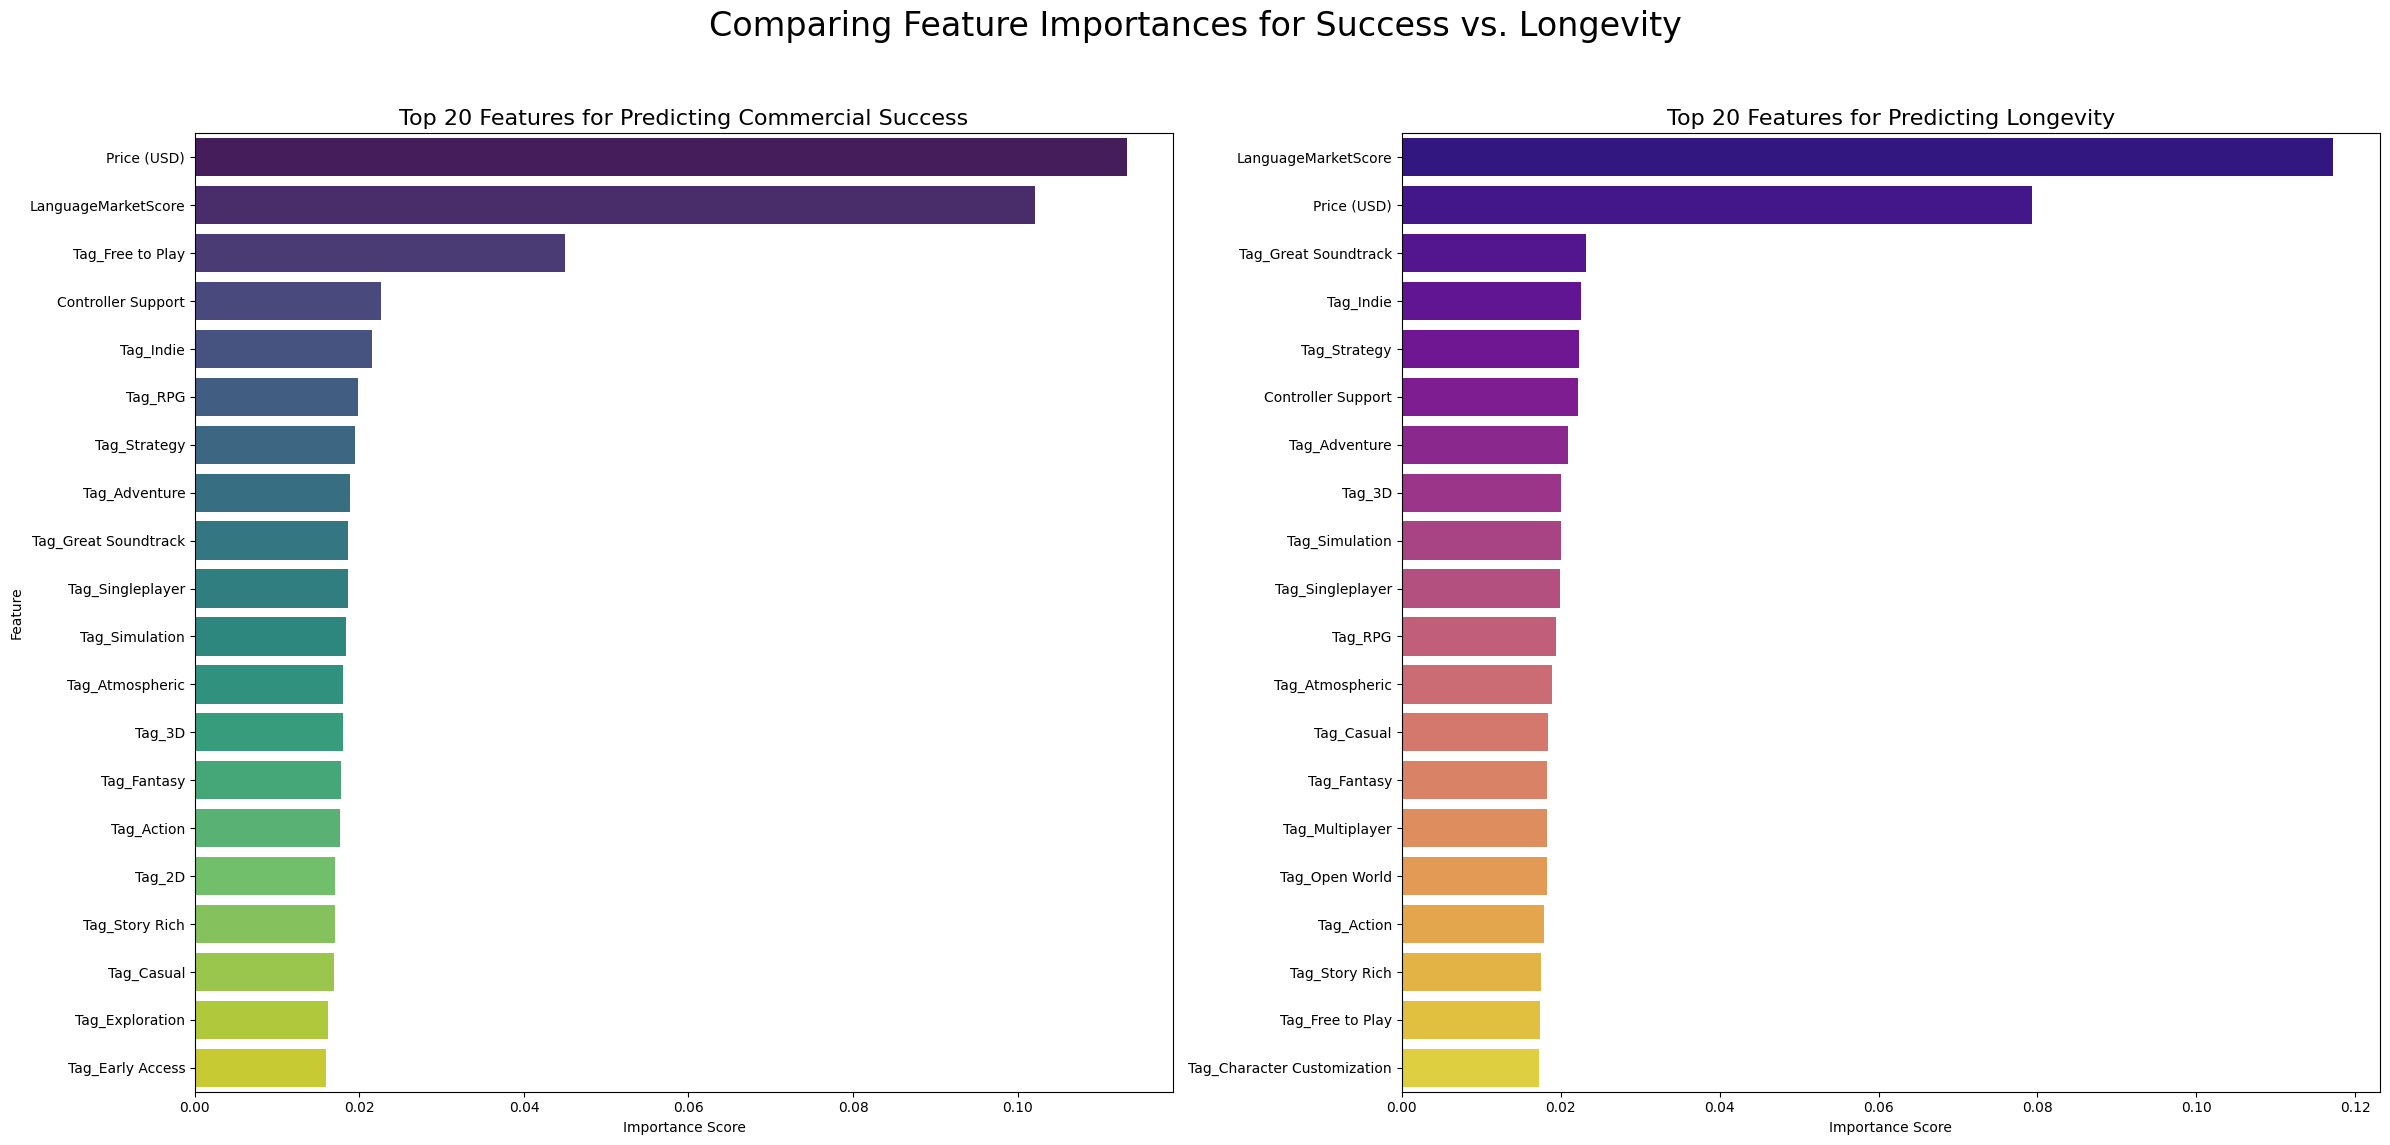

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Comparing Feature Importances for Success vs. Longevity', fontsize=24)

importances_success = success_model.feature_importances_
feature_importance_success = pd.Series(importances_success, index=X.columns).nlargest(20)

sns.barplot(x=feature_importance_success, y=feature_importance_success.index, palette='viridis', ax=axes[0], hue=feature_importance_success.index, legend=False)
axes[0].set_title('Top 20 Features for Predicting Commercial Success', fontsize=16)
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Feature')

importances_longevity = longevity_model.feature_importances_
feature_importance_longevity = pd.Series(importances_longevity, index=X.columns).nlargest(20)

sns.barplot(x=feature_importance_longevity, y=feature_importance_longevity.index, palette='plasma', ax=axes[1], hue=feature_importance_longevity.index, legend=False)
axes[1].set_title('Top 20 Features for Predicting Longevity', fontsize=16)
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Train and Evaluate Both XGBoost Models

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

print("="*60)
print("Training XGBoost Model 1: Commercial Success (SuccessTier)")
print("="*60)

le_success = LabelEncoder()
y_success_encoded = le_success.fit_transform(y_success)

X_train_s, X_test_s, y_train_s_encoded, y_test_s_encoded = train_test_split(
    X, y_success_encoded, test_size=0.2, random_state=42, stratify=y_success_encoded
)

print("\n--- Training the XGBClassifier for Success...")
xgb_model_success = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model_success.fit(X_train_s, y_train_s_encoded)
print("Success Model training complete.")

predictions_s = xgb_model_success.predict(X_test_s)
accuracy_s = accuracy_score(y_test_s_encoded, predictions_s)
report_s = classification_report(y_test_s_encoded, predictions_s, target_names=le_success.classes_)

print("\n--- XGBoost Success Model Performance ---")
print(f"Overall Accuracy: {accuracy_s:.2%}")
print("\n--- Detailed Classification Report (SuccessTier) ---")
print(report_s)

print("\n\n" + "="*60)
print("Training XGBoost Model 2: Game Longevity (LongevityTier)")
print("="*60)

le_longevity = LabelEncoder()
y_longevity_encoded = le_longevity.fit_transform(y_longevity)

X_train_l, X_test_l, y_train_l_encoded, y_test_l_encoded = train_test_split(
    X, y_longevity_encoded, test_size=0.2, random_state=42, stratify=y_longevity_encoded
)

print("\n--- Training the XGBClassifier for Longevity...")
xgb_model_longevity = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model_longevity.fit(X_train_l, y_train_l_encoded)
print("Longevity Model training complete.")

predictions_l = xgb_model_longevity.predict(X_test_l)
accuracy_l = accuracy_score(y_test_l_encoded, predictions_l)
report_l = classification_report(y_test_l_encoded, predictions_l, target_names=le_longevity.classes_)

print("\n--- XGBoost Longevity Model Performance ---")
print(f"Overall Accuracy: {accuracy_l:.2%}")
print("\n--- Detailed Classification Report (LongevityTier) ---")
print(report_l)

### Training XGBoost Model 1: Commercial Success (SuccessTier) ###

--- Training the XGBClassifier for Success...
Success Model training complete.

--- XGBoost Success Model Performance ---
Overall Accuracy: 40.35%

--- Detailed Classification Report (SuccessTier) ---
                 precision    recall  f1-score   support

    Blockbuster       0.33      0.18      0.24        49
      Major Hit       0.38      0.36      0.37       146
 Modest Success       0.39      0.41      0.40       195
  Niche or Flop       0.60      0.74      0.66       194
    Notable Hit       0.30      0.28      0.29       195
Solid Performer       0.29      0.28      0.28       195

       accuracy                           0.40       974
      macro avg       0.38      0.37      0.37       974
   weighted avg       0.39      0.40      0.39       974



### Training XGBoost Model 2: Game Longevity (LongevityTier) ###

--- Training the XGBClassifier for Longevity...
Longevity Model training complete.

--- XG

### Feature Selection with Boruta

In [ ]:
from boruta import BorutaPy
from xgboost import XGBClassifier
import numpy as np

print("="*60)
print("Running Boruta for Model 1: Commercial Success")
print("="*60)

xgb_success = XGBClassifier(random_state=42, eval_metric='mlogloss')
boruta_selector_success = BorutaPy(
    estimator=xgb_success,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

print("--- Running Boruta Feature Selection... (This may take a few minutes) ---")
boruta_selector_success.fit(X.values, y_success_encoded)
print("\nBoruta run for Success Model complete.")

selected_features_mask_s = boruta_selector_success.support_
X_boruta_success = X.iloc[:, selected_features_mask_s]

print(f"\nBoruta selected {X_boruta_success.shape[1]} features for the Success Model.")
print("\n--- Selected Features for Success ---")
print(X_boruta_success.columns.tolist())

print("\n\n" + "="*60)
print("Running Boruta for Model 2: Game Longevity")
print("="*60)

xgb_longevity = XGBClassifier(random_state=42, eval_metric='mlogloss')
boruta_selector_longevity = BorutaPy(
    estimator=xgb_longevity,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

print("--- Running Boruta Feature Selection... (This may take a few minutes) ---")
boruta_selector_longevity.fit(X.values, y_longevity_encoded)
print("\nBoruta run for Longevity Model complete.")

selected_features_mask_l = boruta_selector_longevity.support_
X_boruta_longevity = X.iloc[:, selected_features_mask_l]

print(f"\nBoruta selected {X_boruta_longevity.shape[1]} features for the Longevity Model.")
print("\n--- Selected Features for Longevity ---")
print(X_boruta_longevity.columns.tolist())

print("\n\nTwo new DataFrames, 'X_boruta_success' and 'X_boruta_longevity', have been created.")

### Running Boruta for Model 1: Commercial Success ###
--- Running Boruta Feature Selection... (This may take a few minutes) ---
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	22
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	22
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	22
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	22
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	21
Rejected: 	20
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	21
Rejected: 	20
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	2

### Train and Evaluate Models with Boruta-Selected Features

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

print("="*60)
print("Retraining Success Model with Boruta Features")
print("="*60)

X_train_bs, X_test_bs, y_train_s_encoded, y_test_s_encoded = train_test_split(
    X_boruta_success, y_success_encoded, test_size=0.2, random_state=42, stratify=y_success_encoded
)

print("\n--- Training final XGBClassifier for Success...")
final_xgb_success = XGBClassifier(random_state=42, eval_metric='mlogloss')
final_xgb_success.fit(X_train_bs, y_train_s_encoded)
print("Final Success Model training complete.")

predictions_bs = final_xgb_success.predict(X_test_bs)
accuracy_bs = accuracy_score(y_test_s_encoded, predictions_bs)
report_bs = classification_report(y_test_s_encoded, predictions_bs, target_names=le_success.classes_)

print("\n--- Final Success Model Performance (Boruta Features) ---")
print(f"Overall Accuracy: {accuracy_bs:.2%}")
print("\n--- Detailed Classification Report (SuccessTier) ---")
print(report_bs)

previous_success_accuracy = 0.5051
print("\n--- Final Comparison (Success Model) ---")
print(f"XGBoost Accuracy (All Features):    {previous_success_accuracy:.2%}")
print(f"XGBoost Accuracy (Boruta Features): {accuracy_bs:.2%}")

print("\n\n" + "="*60)
print("Retraining Longevity Model with Boruta Features")
print("="*60)

X_train_bl, X_test_bl, y_train_l_encoded, y_test_l_encoded = train_test_split(
    X_boruta_longevity, y_longevity_encoded, test_size=0.2, random_state=42, stratify=y_longevity_encoded
)

print("\n--- Training final XGBClassifier for Longevity...")
final_xgb_longevity = XGBClassifier(random_state=42, eval_metric='mlogloss')
final_xgb_longevity.fit(X_train_bl, y_train_l_encoded)
print("Final Longevity Model training complete.")

predictions_bl = final_xgb_longevity.predict(X_test_bl)
accuracy_bl = accuracy_score(y_test_l_encoded, predictions_bl)
report_bl = classification_report(y_test_l_encoded, predictions_bl, target_names=le_longevity.classes_)

print("\n--- Final Longevity Model Performance (Boruta Features) ---")
print(f"Overall Accuracy: {accuracy_bl:.2%}")
print("\n--- Detailed Classification Report (LongevityTier) ---")
print(report_bl)

previous_longevity_accuracy = 0.61
print("\n--- Final Comparison (Longevity Model) ---")
print(f"XGBoost Accuracy (All Features):    {previous_longevity_accuracy:.2%}")
print(f"XGBoost Accuracy (Boruta Features): {accuracy_bl:.2%}")

### Retraining Success Model with Boruta Features ###

--- Training final XGBClassifier for Success...
Final Success Model training complete.

--- Final Success Model Performance (Boruta Features) ---
Overall Accuracy: 38.91%

--- Detailed Classification Report (SuccessTier) ---
                 precision    recall  f1-score   support

    Blockbuster       0.36      0.20      0.26        49
      Major Hit       0.36      0.36      0.36       146
 Modest Success       0.38      0.40      0.39       195
  Niche or Flop       0.59      0.70      0.64       194
    Notable Hit       0.30      0.31      0.30       195
Solid Performer       0.26      0.22      0.24       195

       accuracy                           0.39       974
      macro avg       0.37      0.36      0.37       974
   weighted avg       0.38      0.39      0.38       974


--- Final Comparison (Success Model) ---
XGBoost Accuracy (All Features):    50.51%
XGBoost Accuracy (Boruta Features): 38.91%


### Retraining Lo

### Hyperparameter Tuning for Both Models (Using All Features)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

param_grid_focused = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9]
}

print("="*60)
print("Tuning Model 1: Commercial Success (SuccessTier)")
print("="*60)

X_train_s, X_test_s, y_train_s_encoded, y_test_s_encoded = train_test_split(
    X, y_success_encoded, test_size=0.2, random_state=42, stratify=y_success_encoded
)

xgb_for_grid_s = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search_success = GridSearchCV(
    estimator=xgb_for_grid_s, param_grid=param_grid_focused,
    cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2
)

print("--- Starting Exhaustive Grid Search for Success Model... (This WILL take a long time) ---")
grid_search_success.fit(X_train_s, y_train_s_encoded)
print("\nGrid Search for Success Model complete.")

print("\n--- Best Hyperparameters Found for Success Model ---")
print(grid_search_success.best_params_)
final_tuned_success_model = grid_search_success.best_estimator_
predictions_s = final_tuned_success_model.predict(X_test_s)
report_s = classification_report(y_test_s_encoded, predictions_s, target_names=le_success.classes_)

print("\n--- Final Performance of the Tuned Success Model ---")
print(report_s)

print("\n\n" + "="*60)
print("Tuning Model 2: Game Longevity (LongevityTier)")
print("="*60)

X_train_l, X_test_l, y_train_l_encoded, y_test_l_encoded = train_test_split(
    X, y_longevity_encoded, test_size=0.2, random_state=42, stratify=y_longevity_encoded
)

xgb_for_grid_l = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search_longevity = GridSearchCV(
    estimator=xgb_for_grid_l, param_grid=param_grid_focused,
    cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2
)

print("--- Starting Exhaustive Grid Search for Longevity Model... (This WILL take a long time) ---")
grid_search_longevity.fit(X_train_l, y_train_l_encoded)
print("\nGrid Search for Longevity Model complete.")

print("\n--- Best Hyperparameters Found for Longevity Model ---")
print(grid_search_longevity.best_params_)
final_tuned_longevity_model = grid_search_longevity.best_estimator_
predictions_l = final_tuned_longevity_model.predict(X_test_l)
report_l = classification_report(y_test_l_encoded, predictions_l, target_names=le_longevity.classes_)

print("\n--- Final Performance of the Tuned Longevity Model ---")
print(report_l)

### Tuning Model 1: Commercial Success (SuccessTier) ###
--- Starting Exhaustive Grid Search for Success Model... (This WILL take a long time) ---
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Grid Search for Success Model complete.

--- Best Hyperparameters Found for Success Model ---
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

--- Final Performance of the Tuned Success Model ---
                 precision    recall  f1-score   support

    Blockbuster       0.38      0.16      0.23        49
      Major Hit       0.41      0.41      0.41       146
 Modest Success       0.44      0.45      0.44       195
  Niche or Flop       0.59      0.77      0.67       194
    Notable Hit       0.36      0.30      0.33       195
Solid Performer       0.32      0.30      0.31       195

       accuracy                           0.43       974
      macro avg       0.41      0.40      0.40       974
   weighted avg       0.42      0.43      0.42  

### Save the Best-Performing Models and Components

In [ ]:
import joblib

joblib.dump(xgb_model_success, 'success_model.pkl')
joblib.dump(le_success, 'success_label_encoder.pkl')

joblib.dump(xgb_model_longevity, 'longevity_model.pkl')
joblib.dump(le_longevity, 'longevity_label_encoder.pkl')

final_feature_list = X.columns.tolist()
joblib.dump(final_feature_list, 'final_feature_list.pkl')

print("The following files have been saved:")
print("- success_model.pkl (The Commercial Success model)")
print("- success_label_encoder.pkl")
print("- longevity_model.pkl (The Game Longevity model)")
print("- longevity_label_encoder.pkl")
print("- final_feature_list.pkl (The list of input features for both models)")

✅ Success! The following files have been saved:
- success_model.pkl (The Commercial Success model)
- success_label_encoder.pkl
- longevity_model.pkl (The Game Longevity model)
- longevity_label_encoder.pkl
- final_feature_list.pkl (The list of input features for both models)
